# Домашнее задание № 9

In [ ]:
%%capture

!pip install --upgrade keras
!pip install torch torchvision torchaudio
!pip install scikit-learn pandas matplotlib transformers -U

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.1.1


In [ ]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

### Дообучение Bert


In [ ]:
data = pd.read_csv('lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [ ]:
data.topic.value_counts()

topic
Из жизни             55
Наука и техника      54
Бывший СССР          54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: count, dtype: int64

In [ ]:
def consume_hf_model(name: str):
  tokenizer = AutoTokenizer.from_pretrained(name)
  model_bert = AutoModel.from_pretrained(name)
  return tokenizer, model_bert


model1 = "distilbert-base-multilingual-cased"
model2 = "DeepPavlov/rubert-base-cased"
model3 = "ai-forever/ruBert-base"


tokenizer1, amod1 = consume_hf_model(model1)
tokenizer2, amod2 = consume_hf_model(model2)
tokenizer3, amod3 = consume_hf_model(model3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

In [ ]:
def yield_data(tokenizer):
  X = []

  for text in data.title:
      ids = tokenizer.encode(text)
      X.append(ids[:512])

  return X

X1 = yield_data(tokenizer1)
X2 = yield_data(tokenizer2)
X3 = yield_data(tokenizer3)

In [ ]:
X1 = keras.preprocessing.sequence.pad_sequences(X1, padding='post', maxlen=512)
X2 = keras.preprocessing.sequence.pad_sequences(X2, padding='post', maxlen=512)
X3 = keras.preprocessing.sequence.pad_sequences(X3, padding='post', maxlen=512)

In [ ]:
print(X1.shape)
print(X2.shape)
print(X3.shape)

(607, 512)
(607, 512)
(607, 512)


In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
train1_index, valid1_index = train_test_split(list(range(len(X1))), test_size=0.05, stratify=data.topic)
train2_index, valid2_index = train_test_split(list(range(len(X2))), test_size=0.05, stratify=data.topic)
train3_index, valid3_index = train_test_split(list(range(len(X3))), test_size=0.05, stratify=data.topic)

In [ ]:
def split_(train_index, valid_index, X):
  X_train, y_train = X[train_index], y[train_index]
  X_valid, y_valid = X[valid_index], y[valid_index]
  return X_train, y_train, X_valid, y_valid

X_train1, y_train1, X_valid1, y_valid1 = split_(train1_index, valid1_index, X1)
X_train2, y_train2, X_valid2, y_valid2 = split_(train2_index, valid2_index, X2)
X_train3, y_train3, X_valid3, y_valid3 = split_(train3_index, valid3_index, X3)

In [ ]:
def freezer(model):
  change = False
  for param in model.parameters():
    param.requires_grad = change
    change = not change


freezer(amod1)
freezer(amod2)
freezer(amod3)

In [ ]:
class bert_wrapper(keras.Model):
    def __init__(self, model_bert, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model_bert = keras.layers.TorchModuleWrapper(model_bert)

    def call(self, inputs):
        x = self.model_bert(inputs)
        return x[0]

In [ ]:
def tune_model(model):
  input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                      name="input_ids")


  output = bert_wrapper(model)(input_word_ids)
  # добавим дропаут чтобы не переобучалось
  drop = keras.layers.Dropout(0.1)(output[:, 0]) # [0][:, 0] - означает что мы берем первое
                                                      # состояние у всех текстов в батче
  dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

  model_clf = keras.Model(inputs=[input_word_ids], outputs=dense)

  # обычно при дообучении трансформеров нужно ставить очень маленький лосс
  # но когда мы обучаем только итоговый классификатор то можно ставить побольше
  model_clf.compile(keras.optimizers.Adam(learning_rate=1e-3),
                    loss='categorical_crossentropy',
                    metrics=['accuracy',
                            keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])
  return model_clf

model_clf1 = tune_model(amod1)
model_clf2 = tune_model(amod2)
model_clf3 = tune_model(amod3)

In [ ]:
def to_cuda(model_clf):
  if torch.cuda.is_available():
      model_clf.to('cuda')

to_cuda(model_clf1)
to_cuda(model_clf2)
to_cuda(model_clf3)

In [ ]:
# ошибка с device meta, а как ее нормально исправить?
model_clf1.fit(torch.LongTensor(X_train1), torch.LongTensor(y_train1),
          validation_data=(torch.LongTensor(X_valid1), torch.LongTensor(y_valid1)),
          batch_size=20,
          epochs=5) # тут в предупреждения пишут: recommend passing in an `attention_mask`, как это сделать?
          # и еще такой вопрос: если я скачиваю модель, то можно как-то убрать какие-то ее слои с помощью керас апи?

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 785ms/step - accuracy: 0.2237 - loss: 2.5212 - rec_prec: 0.0113 - val_accuracy: 0.2258 - val_loss: 2.5625 - val_rec_prec: 0.0323
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 751ms/step - accuracy: 0.2253 - loss: 2.4482 - rec_prec: 0.0116 - val_accuracy: 0.0968 - val_loss: 2.5988 - val_rec_prec: 0.0000e+00
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 728ms/step - accuracy: 0.1854 - loss: 2.4835 - rec_prec: 0.0158 - val_accuracy: 0.2581 - val_loss: 2.5426 - val_rec_prec: 0.0000e+00
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 740ms/step - accuracy: 0.2049 - loss: 2.4657 - rec_prec: 0.0068 - val_accuracy: 0.1935 - val_loss: 2.5659 - val_rec_prec: 0.0323
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 750ms/step - accuracy: 0.2166 - loss: 2.4791 - rec_prec: 0.0354 - val_accuracy: 0.2258 - val_loss: 2.5496 - val_rec_prec: 0.0323


In [ ]:
model_clf2.fit(torch.LongTensor(X_train2), torch.LongTensor(y_train2),
          validation_data=(torch.LongTensor(X_valid2), torch.LongTensor(y_valid2)),
          batch_size=20,
          epochs=5)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.1556 - loss: 2.6112 - rec_prec: 0.0029 - val_accuracy: 0.1613 - val_loss: 2.6651 - val_rec_prec: 0.0000e+00
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.1599 - loss: 2.6255 - rec_prec: 0.0066 - val_accuracy: 0.1613 - val_loss: 2.6503 - val_rec_prec: 0.0000e+00
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1619 - loss: 2.6032 - rec_prec: 0.0058 - val_accuracy: 0.1613 - val_loss: 2.6280 - val_rec_prec: 0.0000e+00
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1394 - loss: 2.6109 - rec_prec: 0.0078 - val_accuracy: 0.1290 - val_loss: 2.6625 - val_rec_prec: 0.0000e+00
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1568 - loss: 2.6003 - rec_prec: 0.0139 - val_accuracy: 0.2258 - val_loss: 2.6395 - val_rec_prec: 0.0000e+00


In [ ]:
model_clf3.fit(torch.LongTensor(X_train3), torch.LongTensor(y_train3),
          validation_data=(torch.LongTensor(X_valid3), torch.LongTensor(y_valid3)),
          batch_size=20,
          epochs=5)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.1643 - loss: 2.6071 - rec_prec: 8.4921e-04 - val_accuracy: 0.2258 - val_loss: 2.6021 - val_rec_prec: 0.0323
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.1982 - loss: 2.5628 - rec_prec: 0.0027 - val_accuracy: 0.2258 - val_loss: 2.6323 - val_rec_prec: 0.0323
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1514 - loss: 2.5181 - rec_prec: 4.1667e-04 - val_accuracy: 0.2581 - val_loss: 2.6464 - val_rec_prec: 0.0645
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1764 - loss: 2.5285 - rec_prec: 0.0094 - val_accuracy: 0.2258 - val_loss: 2.5668 - val_rec_prec: 0.0000e+00
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.2360 - loss: 2.4115 - rec_prec: 0.0016 - val_accuracy: 0.2258 - val_loss: 2.5260 - val_rec_prec: 0.0323


In [ ]:
def sum_for_model(model_clf):
  print(model_clf.history.history.keys())
  plt.plot(model_clf.history.history['accuracy'])
  plt.plot(model_clf.history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


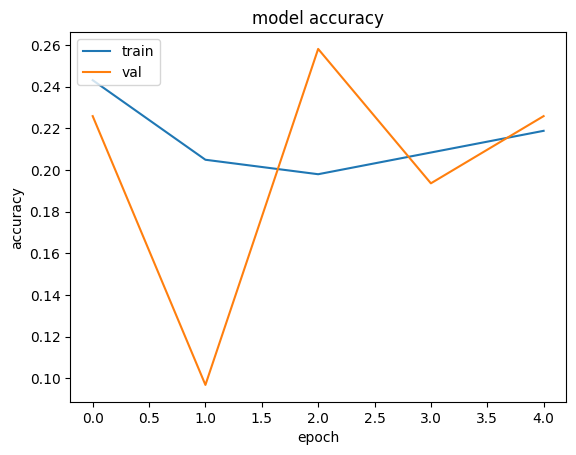

In [ ]:
sum_for_model(model_clf1)

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


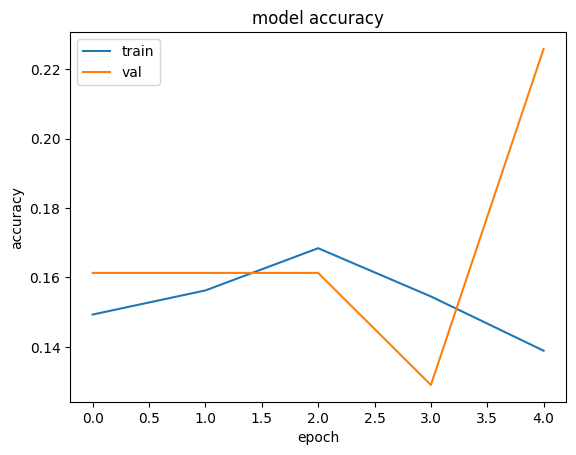

In [ ]:
sum_for_model(model_clf2)

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


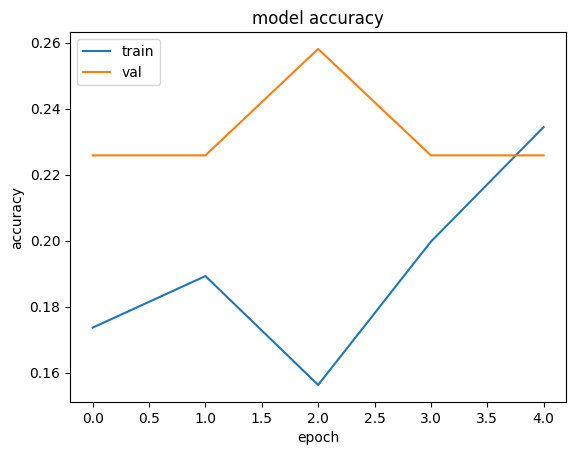

In [ ]:
sum_for_model(model_clf3)

In [ ]:
def report(model_clf, X_valid, y_valid):
  pred = model_clf.predict(X_valid, batch_size=10).argmax(1)
  print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

In [ ]:
report(model_clf1, X_valid1, y_valid1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         1
      Бывший СССР       1.00      0.33      0.50         3
         Ценности       0.00      0.00      0.00         2
           Бизнес       0.00      0.00      0.00         2
       Библиотека       0.00      0.00      0.00         0
        Экономика       0.00      0.00      0.00         2
         Из жизни       0.33      0.67      0.44         3
              Дом       0.00      0.00      0.00         2
            Спорт       0.00      0.00      0.00         2
   Интернет и СМИ       0.00      0.00      0.00         2
Силовые структуры       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00         2
  Наука и техника       0.18      1.00      0.30         3
             Крым       0.00      0.00      0.00         0
         Культура       1.00      0.33      0.50         3
              Ми

In [ ]:
report(model_clf2, X_valid2, y_valid2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         1
      Бывший СССР       0.50      0.33      0.40         3
         Ценности       0.00      0.00      0.00         2
           Бизнес       0.50      1.00      0.67         2
       Библиотека       0.00      0.00      0.00         0
        Экономика       0.00      0.00      0.00         2
         Из жизни       0.00      0.00      0.00         3
              Дом       0.33      0.50      0.40         2
            Спорт       0.00      0.00      0.00         2
   Интернет и СМИ       0.00      0.00      0.00         2
Силовые структуры       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00         2
  Наука и техника       0.00      0.00      0.00         3
             Крым       0.00      0.00      0.00         0
         Культура       0.16      1.00      0.27         3
              Ми

In [ ]:
report(model_clf3, X_valid2, y_valid3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         1
      Бывший СССР       0.00      0.00      0.00         3
         Ценности       0.00      0.00      0.00         2
           Бизнес       0.00      0.00      0.00         2
       Библиотека       0.00      0.00      0.00         0
        Экономика       0.00      0.00      0.00         2
         Из жизни       0.00      0.00      0.00         3
              Дом       0.00      0.00      0.00         2
            Спорт       0.25      0.50      0.33         2
   Интернет и СМИ       0.00      0.00      0.00         2
Силовые структуры       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00         2
  Наука и техника       0.33      0.33      0.33         3
             Крым       0.00      0.00      0.00         0
         Культура       0.11      0.67      0.18         3
              Ми

In [ ]:
# модель из семинара показала самый лучший результат
# хотя другие модели были уже дообучены на русском языке

### Дообучение GPT.




In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [ ]:
DEVICE = torch.device("cuda:0")

# Загружаем модель ruGPT от сбера
model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, use_cache=False).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling

# Сохраним обучающие данные в .txt файл
train_path = 'recipes.txt'

# Создание датасета
train_dataset = TextDataset(tokenizer=tokenizer, file_path=train_path,block_size=64,
                            overwrite_cache=True)

# специальный класс который будет подавать в модель данные в нужном ей виде
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir= "./finetuned",
    overwrite_output_dir=True,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=16,
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers = (torch.optim.AdamW(model.parameters(), lr=1e-5),None) # Optimizer and lr scheduler
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=100, training_loss=0.21590078353881836, metrics={'train_runtime': 90.3443, 'train_samples_per_second': 64.199, 'train_steps_per_second': 1.107, 'total_flos': 189436723200000.0, 'train_loss': 0.21590078353881836, 'epoch': 100.0})

In [ ]:
def gen(text: str) -> str:
  input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
  model.eval()
  with torch.no_grad():
      out = model.generate(input_ids,
                          do_sample=True,
                          temperature=0.8,
                          top_k=50,
                          num_beams=5,
                          max_length=300,
                          repetition_penalty=3.5,
                          no_repeat_ngram_size=2
                          )

  generated_text = list(map(tokenizer.decode, out))[0]
  return generated_text

In [ ]:
result = gen("Рецепт супа")

In [ ]:
result # тексты на которых обучалась модель содержали особый формат шагов (номер шага: <текст>;), GPT его сохранила

'Рецепт супа из говядины с овощами и зеленью:1:Морковь натираем на крупной терке, лук мелко режем;2:Очистим картофель от кожуры, нарежем его кубиками. Добавим к нему измельченный репчатый лук.;3:Тщательно перемешаем все содержимое кастрюли.;4:Влейте в кастрюлю холодную воду и доведите до кипения.;5:Добавьте щепотку соли и сахар по вкусу.;6:Проварите суп около 40 минут.;7:После выключите плиту, дайте настояться пару часов.;8:Перед подачей полейте образовавшимся бульоном морковь и добавьте туда же несколько веточек петрушки. Приятного аппетита!\nИнгредиенты (на 6 порций):Мясо говяжье - 3 шт.,мякоть репчатого лука - 2 штуки.,оливковое масло - 1 ст. ложка.,молотый черный перец горошком - 4-5 зубчиков.,лавровый лист - 5-6 горошин.,уксус яблочный - 8-9 зерен.,растительное масло для жарки мяса,молоко - 10-12 столовых ложек.,масло сливочное комнатной температуры - 15-20 мл.,сливочное масло растительное для смазывания рулетов,майонез,зелень укропа,петрушку,помидоры,апельсиновое варенье,орехи,см

In [ ]:
print('\n'.join(result.split(';')))

Рецепт супа из говядины с овощами и зеленью:1:Морковь натираем на крупной терке, лук мелко режем
2:Очистим картофель от кожуры, нарежем его кубиками. Добавим к нему измельченный репчатый лук.
3:Тщательно перемешаем все содержимое кастрюли.
4:Влейте в кастрюлю холодную воду и доведите до кипения.
5:Добавьте щепотку соли и сахар по вкусу.
6:Проварите суп около 40 минут.
7:После выключите плиту, дайте настояться пару часов.
8:Перед подачей полейте образовавшимся бульоном морковь и добавьте туда же несколько веточек петрушки. Приятного аппетита!
Ингредиенты (на 6 порций):Мясо говяжье - 3 шт.,мякоть репчатого лука - 2 штуки.,оливковое масло - 1 ст. ложка.,молотый черный перец горошком - 4-5 зубчиков.,лавровый лист - 5-6 горошин.,уксус яблочный - 8-9 зерен.,растительное масло для жарки мяса,молоко - 10-12 столовых ложек.,масло сливочное комнатной температуры - 15-20 мл.,сливочное масло растительное для смазывания рулетов,майонез,зелень укропа,петрушку,помидоры,апельсиновое варенье,орехи,смет

In [ ]:
print('\n'.join(gen("Рецепт пирога").split(';')))

Рецепт пирога с яблоками и курагой.
1:Яблоки очистите от кожуры, нарежьте кубиками среднего размера.
2:В небольшой кастрюле доведите яблоки до кипения, снимите пену.
3:Отделите белки от желтков
4:Желтки взбейте миксером до однородной массы.
5:Измельчите орехи в блендере.
6:Раскатайте тесто в тонкий пласт.
7:Выложите его на противень, застеленный пергаментной бумагой., выпекайте при температуре 180 градусов около 40 минут.
8:За час до окончания выпечки достаньте пирог из духовки и дайте ему немного остыть.
9:Доведите до комнатной температуры, после чего остудите.
10:Пирог приобретет золотисто-коричневый цвет.
11:Перед подачей полейте его растопленным сливочным маслом и отправьте в морозильную камеру.
12:Для украшения можно использовать вареную сгущенку или пельмени.
13:Приятного аппетита!
Первое, что нужно сделать, это вымойте руки и хорошенько прополощите рот. Если у вас жирная кожа, то выпейте стакан теплой воды с лимонным соком. Добавьте щепотку ванильного сахара и перемешайте все со